Elad Armoni - 206157323 and
Ofek Begerano - 318435195

In [ ]:
%pip install pandas
%pip install numpy
%pip install networkx
%pip install matplotlib
%pip install datetime
%pip install plotly
%pip install seaborn
%pip install scipy

In [9]:
import pandas as pd
import networkx as nx
from datetime import datetime
import numpy as np
import plotly.graph_objects as go
import requests
import io

Data Preparation

include create new columns for use them later in the graph

In [10]:
tennis_url = 'https://drive.google.com/uc?export=download&id=1uZPyEFQRCUK1hX0Qu3hgOHh1bFbzbH6T'
response = requests.get(tennis_url)
tennis_df = pd.read_csv(io.StringIO(response.text))

tennis_df = tennis_df[~(tennis_df == -1).any(axis=1)]

#Only 2018-2021 games
tennis_df['Date'] = pd.to_datetime(tennis_df['Date'], format='%Y-%m-%d')
tennis_df = tennis_df[(tennis_df['Date'].dt.year >= 2018) & (tennis_df['Date'].dt.year <= 2021)]
tennis_df.dropna(inplace=True)
tennis_df.drop_duplicates(inplace=True)

#Compute numbers of sets in each game
tennis_df['Sets'] = tennis_df['Score'].str.split().apply(lambda x: len(x))

#Compute the power rating - this column compute how much easy/difficult it was for the winner to win the game
#Step 1
tennis_df['Winner_Power'] = 1 - (tennis_df['Sets'] / tennis_df['Best of'])
pd.unique(tennis_df["Winner_Power"])
tennis_df = tennis_df[(tennis_df['Winner_Power']>=0)]
tennis_df = tennis_df[(tennis_df['Winner_Power']<=0.4)]
unique_values = tennis_df['Winner_Power'].unique()
sorted_unique = np.sort(unique_values)[::-1]
# Step 2: Create a mapping from original values to new categories
value_to_category = {val: idx + 1 for idx, val in enumerate(sorted_unique)}
# Step 3: Replace values in the 'Winner_Power' column with their new categories
tennis_df['Winner_Power'] = tennis_df['Winner_Power'].map(value_to_category)
tennis_df = tennis_df.rename(columns={'Winner_Power': 'Power_Rating'})

#Add column for Loser in each game
tennis_df['loser'] = tennis_df.apply(lambda row: row['Player_2'] if row['Winner'] == row['Player_1'] else row['Player_1'], axis=1)

# Create 'Rank_Winner' and 'Rank_Loser' columns
tennis_df['Rank_Winner'] = tennis_df.apply(lambda row: row['Rank_1'] if row['Winner'] == row['Player_1'] else row['Rank_2'], axis=1)
tennis_df['Rank_Loser'] = tennis_df.apply(lambda row: row['Rank_2'] if row['Winner'] == row['Player_1'] else row['Rank_1'], axis=1)

# Create 'Pts_Winner' and 'Pts_Loser' columns
tennis_df['Pts_Winner'] = tennis_df.apply(lambda row: row['Pts_1'] if row['Winner'] == row['Player_1'] else row['Pts_2'], axis=1)
tennis_df['Pts_Loser'] = tennis_df.apply(lambda row: row['Pts_2'] if row['Winner'] == row['Player_1'] else row['Pts_1'], axis=1)

# Create 'Odd_Winner' and 'Odd_Loser' columns
tennis_df['Odd_Winner'] = tennis_df.apply(lambda row: row['Odd_1'] if row['Winner'] == row['Player_1'] else row['Odd_2'], axis=1)
tennis_df['Odd_Loser'] = tennis_df.apply(lambda row: row['Odd_2'] if row['Winner'] == row['Player_1'] else row['Odd_1'], axis=1)

tennis_df=tennis_df.drop(columns=["Rank_1","Rank_2","Pts_1","Pts_2","Odd_1","Odd_2"])
tennis_df=tennis_df.drop(columns=["Player_1","Player_2"])
#Winner is the Source and Loser is the Target - for directed edge from winner to loser
tennis_df = tennis_df.rename(columns={'loser': 'target', 'Winner': 'source'})

tennis_df = tennis_df.rename(columns={'Rank_Winner':'Rank_Source','Rank_Loser':'Rank_Target','Pts_Winner':"Pts_Source"	,'Pts_Loser':'Pts_Target'	,'Odd_Winner':"Odd_Source"	,'Odd_Loser':"Odd_Target"})

Split The Tennis Data To:
1. Before Corona data - 2018-2019
2. Corona data - 2020-2021

In [ ]:
# Ensure the 'Date' column is in datetime format with the correct format
tennis_df['Date'] = pd.to_datetime(tennis_df['Date'], format='%Y-%m-%d')

# Filter for the years 2018-2019 and 2020-2021
before_corona_df = tennis_df[(tennis_df['Date'].dt.year >= 2018) & (tennis_df['Date'].dt.year <= 2019)]
corona_df = tennis_df[(tennis_df['Date'].dt.year >= 2020) & (tennis_df['Date'].dt.year <= 2021)]

# Convert the 'Date' column back to the original string format
before_corona_df['Date'] = before_corona_df['Date'].dt.strftime('%d/%m/%Y')
corona_df['Date'] = corona_df['Date'].dt.strftime('%d/%m/%Y')


In [12]:
before_corona_df.to_csv("before_corona_tennis.csv")
corona_df.to_csv("corona_tennis.csv")

In [13]:
before_corona_df.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,source,Score,Sets,Power_Rating,target,Rank_Source,Rank_Target,Pts_Source,Pts_Target,Odd_Source,Odd_Target
47712,Brisbane International,01/01/2018,ATP250,Outdoor,Hard,1st Round,3,Harrison R.,6-4 3-6 6-2,3,4,Mayer L.,47,52,1010,909,1.61,2.20
47713,Brisbane International,01/01/2018,ATP250,Outdoor,Hard,1st Round,3,Ebden M.,3-6 2-6,2,2,Tiafoe F.,76,79,670,662,2.50,1.50
47714,Brisbane International,01/01/2018,ATP250,Outdoor,Hard,1st Round,3,Zverev M.,6-4 7-5,2,2,Smith J.P.,33,218,1302,235,1.40,2.75
47715,Brisbane International,01/01/2018,ATP250,Outdoor,Hard,1st Round,3,Zeballos H.,3-6 4-6,2,2,Escobedo E.,66,120,768,498,2.20,1.61
47716,Brisbane International,01/01/2018,ATP250,Outdoor,Hard,1st Round,3,Donaldson J.,6-2 6-4,2,2,Thompson J.,54,94,890,593,1.83,1.83


In [14]:
corona_df.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,source,Score,Sets,Power_Rating,target,Rank_Source,Rank_Target,Pts_Source,Pts_Target,Odd_Source,Odd_Target
52777,Qatar Exxon Mobil Open,06/01/2020,ATP250,Outdoor,Hard,1st Round,3,Bublik A.,3-6 4-6,2,2,Mannarino A.,55,43,919,1111,2.00,1.72
52778,Qatar Exxon Mobil Open,06/01/2020,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,7-6 6-4,2,2,Sandgren T.,81,68,638,803,1.57,2.25
52779,Qatar Exxon Mobil Open,06/01/2020,ATP250,Outdoor,Hard,1st Round,3,Verdasco F.,4-6 3-6,2,2,Andujar P.,49,64,1025,867,1.25,3.75
52780,Qatar Exxon Mobil Open,06/01/2020,ATP250,Outdoor,Hard,1st Round,3,Bedene A.,3-6 6-4 6-3,3,4,Ymer M.,58,76,905,681,1.83,1.83
52781,Qatar Exxon Mobil Open,06/01/2020,ATP250,Outdoor,Hard,1st Round,3,Chardy J.,3-6 6-3 3-6,3,4,Barrere G.,54,83,920,636,1.50,2.50


Build Graph for each df - before corona and during corona

In [15]:
#add node for one player to the graph and compute its attributes
def add_node_attributes(G, player, df):
    matches_as_source = df[df['source'] == player]
    matches_as_target = df[df['target'] == player]
    total_games=len(matches_as_source)+len(matches_as_target)
    
    avg_source_rank = matches_as_source['Rank_Source'].sum()
    avg_target_rank = matches_as_target['Rank_Target'].sum()
    avg_source_points = matches_as_source['Pts_Source'].sum()
    avg_target_points = matches_as_target['Pts_Target'].sum()
    power_rating =  df[(df['source'] == player)]["Power_Rating"].mean()
    avg_rank=(avg_source_rank+avg_target_rank)/total_games
    avg_points=(avg_source_points+avg_target_points)/total_games
    G.add_node(player, label=player, avg_rank=avg_rank, avg_points=avg_points, power_rating=power_rating)

#Each node is player , and each edge is directed from winner to loser (edge for each game between two players)
def build_graph(df):
    G = nx.DiGraph()
    for idx, row in df.iterrows():
        winner=row['source']
        loser=row['target']
        if winner not in G:
            add_node_attributes(G, winner, df)
        if loser not in G:
            add_node_attributes(G, loser, df)
        #add for each edge the attributes
        G.add_edge(winner,loser, sets=row['Sets'],court=row['Court'] ,surface=row['Surface'], power_rating=row['Power_Rating'])
    return G


In [16]:
G_before_corona = build_graph(before_corona_df)
G_corona = build_graph(corona_df)

In [17]:
def graph_statistics(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degrees = dict(G.degree())
    avg_degree = sum(degrees.values()) / num_nodes
    density = nx.density(G)
    clustering_coefficient = nx.average_clustering(G)
    
    stats = {
        "Number of Nodes": num_nodes,
        "Number of Edges": num_edges,
        "Average Degree": avg_degree,
        "Density": density,
        "Clustering Coefficient": clustering_coefficient,
    }
    
    return stats

: 

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_graph_statistics(stats1, stats2, labels):

    keys = list(stats1.keys())
    values1 = list(stats1.values())
    values2 = list(stats2.values())
    
    data = {
        "Metric": keys,
        labels[0]: values1,
        labels[1]: values2
    }
    df = pd.DataFrame(data)
    
    # Visualization with a Bar Chart
    df_melt = df.melt(id_vars="Metric", var_name="Graph", value_name="Value")
    plt.figure(figsize=(14, 7))
    barplot = sns.barplot(x="Metric", y="Value", hue="Graph", data=df_melt, palette="viridis")
    plt.xticks(rotation=45)
    plt.title("Graph Statistics Comparison - Bar Chart")
    
    # הוספת המספרים על ה-bars
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


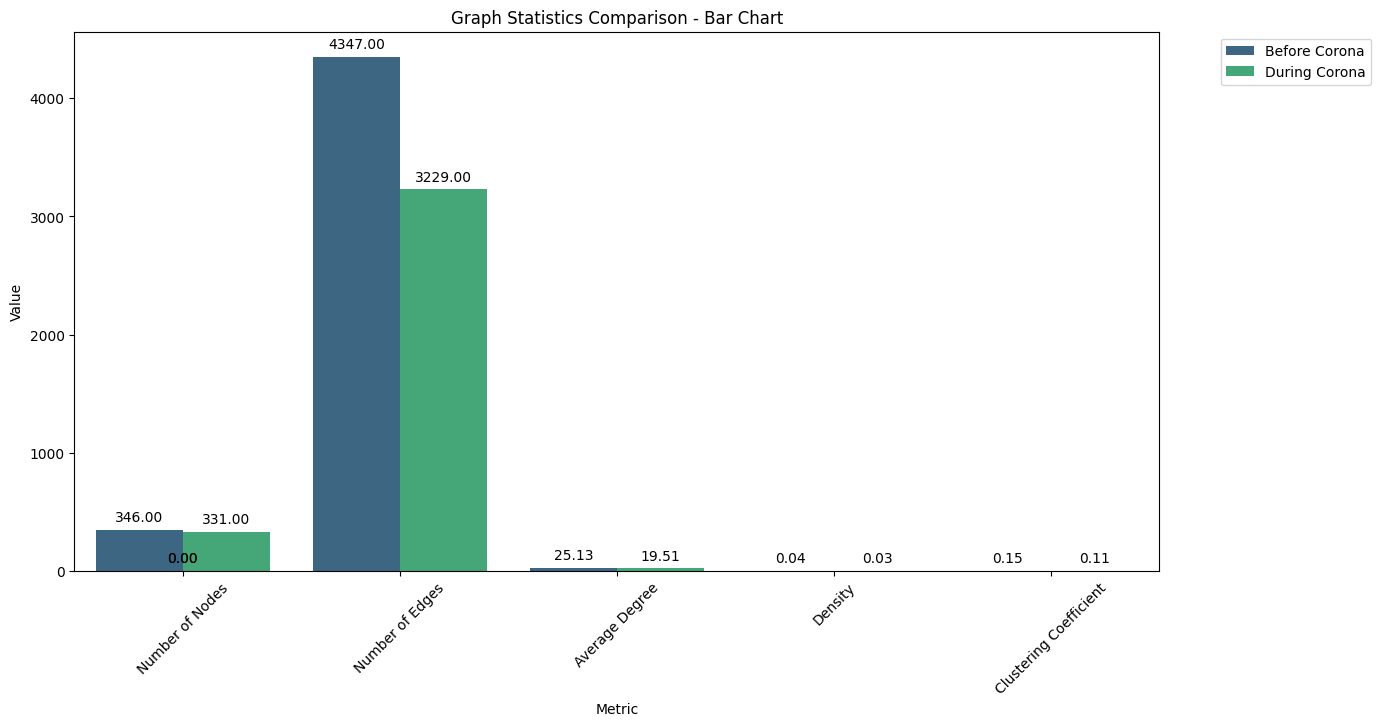

In [ ]:
before_corona_stats = graph_statistics(G_before_corona)
corona_stats = graph_statistics(G_corona)

visualize_graph_statistics(before_corona_stats,corona_stats,["Before Corona","During Corona"])

In [ ]:
def draw_graph(G, title):
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.1) 

    nodes = nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500, alpha=0.7)
    
    edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray', width=2)

    labels = nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_weight='bold')

    plt.title(title, size=15)
    plt.show()

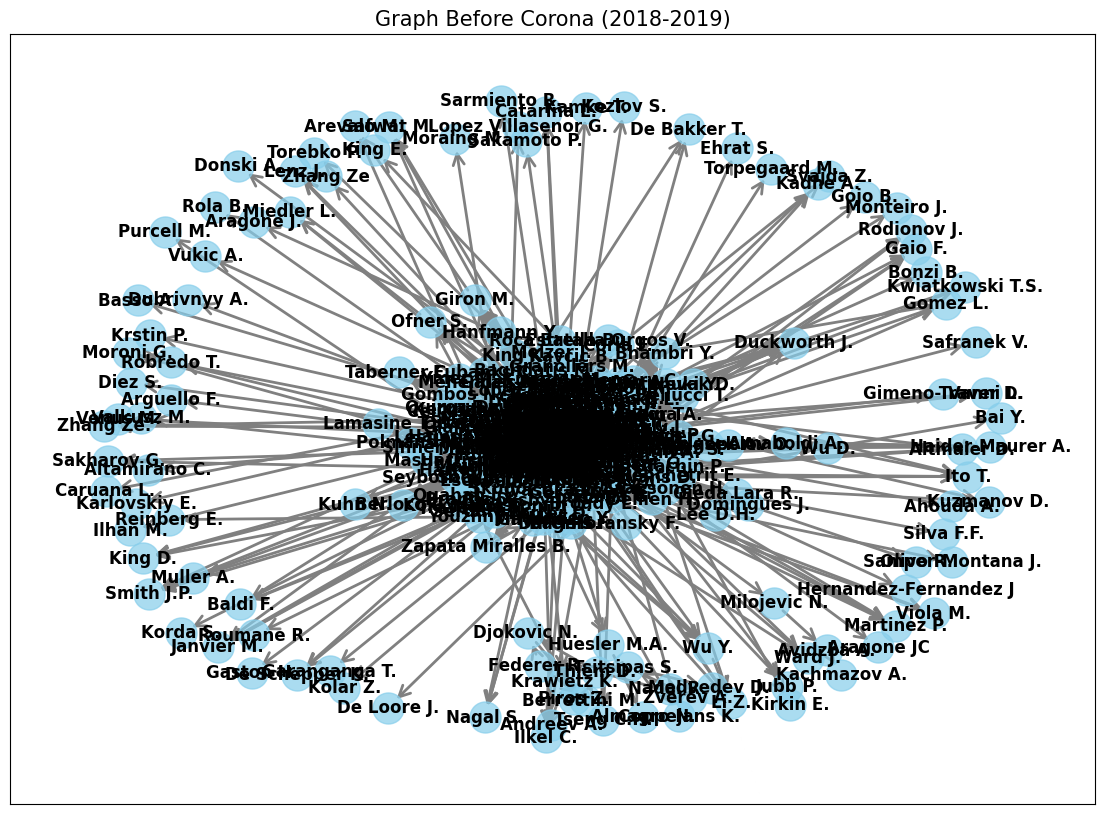

In [ ]:
draw_graph(G_before_corona, 'Graph Before Corona (2018-2019)')

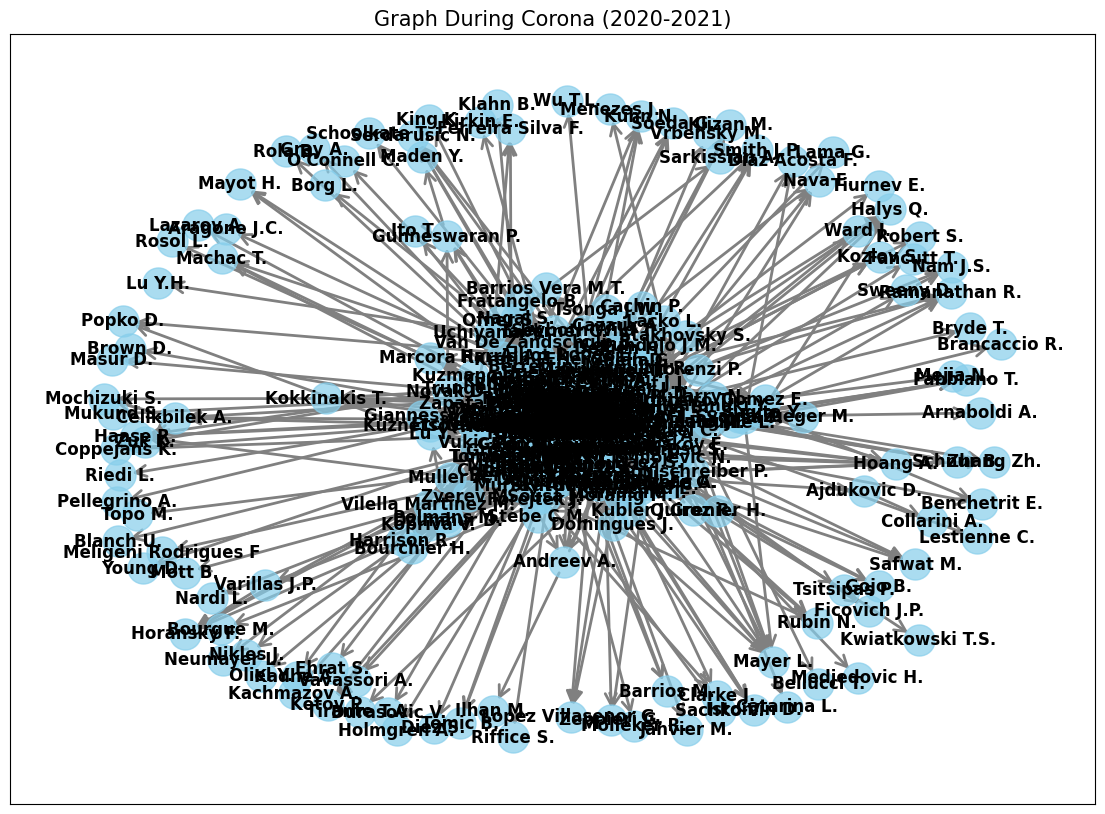

In [ ]:
draw_graph(G_corona, 'Graph During Corona (2020-2021)')

Compute Centrality Measures

In [ ]:
from networkx.algorithms.smallworld import sigma, omega

def calculate_small_world_metrics(G, niter_sigma=100, nrand_sigma=10, niter_omega=5, nrand_omega=10, seed=None):
    G_undirected = G.to_undirected()
    metrics = {}
    metrics['sigma'] = sigma(G_undirected, niter=niter_sigma, nrand=nrand_sigma, seed=seed)
    metrics['omega'] = omega(G_undirected, niter=niter_omega, nrand=nrand_omega, seed=seed)
    return metrics

In [ ]:
from scipy.stats import powerlaw

def calculate_scale_free_exponent(G):
    degree_sequence = [d for n, d in G.degree()]
    degree_sequence = sorted(degree_sequence, reverse=True)
    degree_count = np.bincount(degree_sequence)
    degree_count = degree_count[degree_count > 0]

    # Fit power law
    fit = powerlaw.fit(degree_count)
    exponent = fit[0]

    return exponent

In [ ]:
def calculate_centrality(G):
    centrality_measures = {
    'degree_centrality': nx.degree_centrality,
    'closeness_centrality': nx.closeness_centrality,
    'betweenness_centrality': nx.betweenness_centrality,
    'out_degree_centrality': nx.out_degree_centrality,
    }
    measures = {}
    for name, func in centrality_measures.items():
        measures[name] = func(G)
    return measures

In [ ]:
centrality_measures_before_corona = calculate_centrality(G_before_corona)
centrality_measures_corona = calculate_centrality(G_corona)

In [ ]:
exponent_before_corona=calculate_scale_free_exponent(G_before_corona)
exponent_corona=calculate_scale_free_exponent(G_corona)

print("exponent_before_corona: ",exponent_before_corona)
print("exponent_corona: ",exponent_corona)

exponent_before_corona:  0.05899950067055688
exponent_corona:  0.07478128405269892


In [ ]:
#ההרצה של זה לוקחת המון זמן אז שמנו את זה בהערה
# small_world_before_corona=calculate_small_world_metrics(G_before_corona)
# small_world_corona=calculate_small_world_metrics(G_corona)

In [ ]:
def identify_central_nodes(centrality_measures):
    degree_centrality = centrality_measures['degree_centrality']
    betweenness_centrality = centrality_measures['betweenness_centrality']
    closeness_centrality = centrality_measures['closeness_centrality']
    out_degree_centrality = centrality_measures['out_degree_centrality']
    central_nodes = {
        'degree': sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5],
        'betweenness': sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5],
        'closeness': sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5],
        'out_degree': sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5],
    }

    return central_nodes

central_nodes_before_corona = identify_central_nodes(centrality_measures_before_corona)
central_nodes_corona = identify_central_nodes(centrality_measures_corona)

In [ ]:
def plot_centrality_measures(central_nodes, period):
    centrality_types = ['degree', 'betweenness', 'closeness', 'out_degree']
    fig, axes = plt.subplots(1, len(centrality_types), figsize=(24, 5))
    
    for i, centrality in enumerate(centrality_types):
        nodes, values = zip(*central_nodes[centrality])
        sns.barplot(x=list(values), y=list(nodes), ax=axes[i])
        axes[i].set_title(f'{centrality.capitalize()} Centrality ({period})')
        axes[i].set_xlabel('Centrality Score')
        axes[i].set_ylabel('Players')

    plt.tight_layout()
    plt.show()

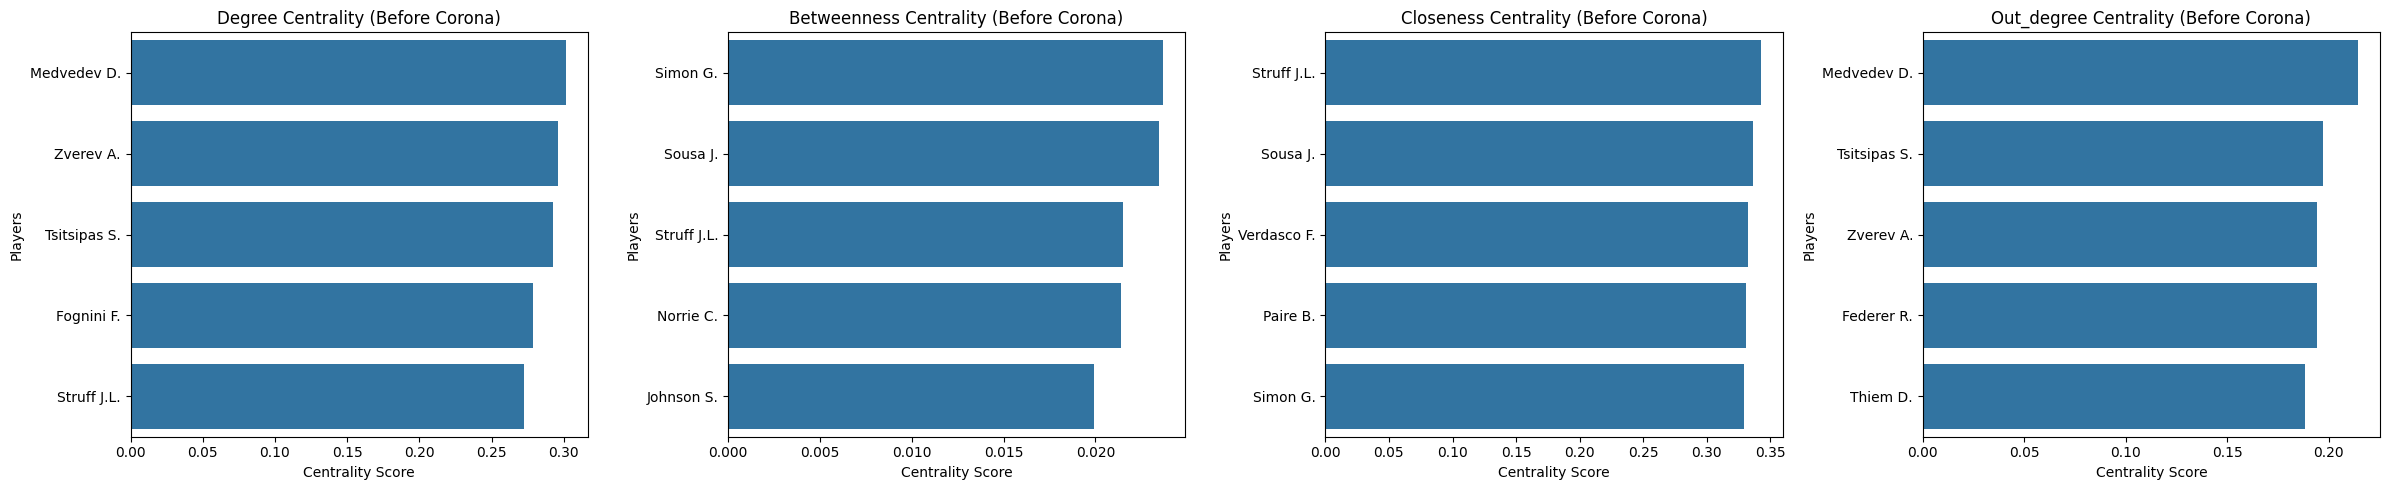

In [ ]:
plot_centrality_measures(central_nodes_before_corona, 'Before Corona')

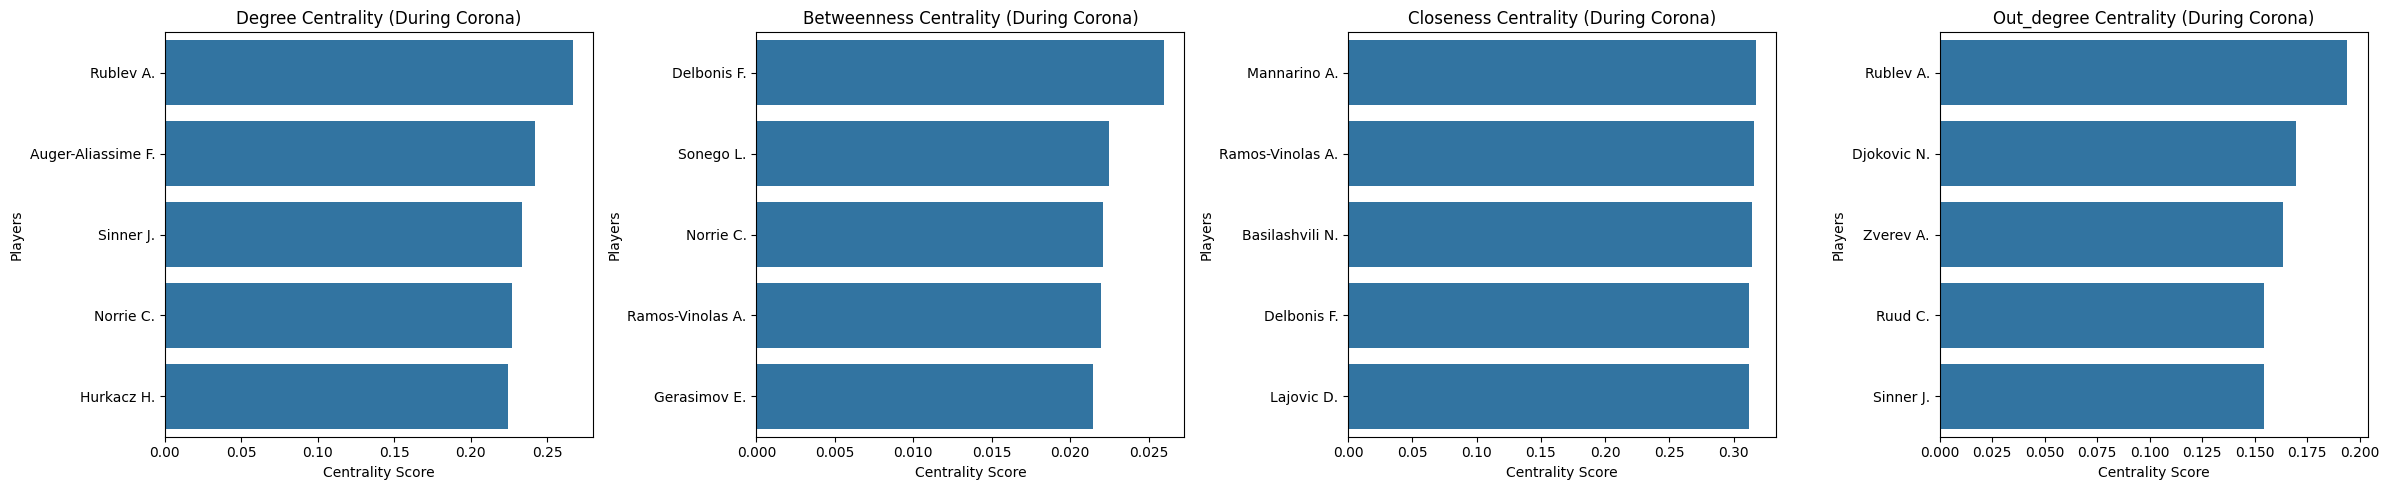

In [ ]:
plot_centrality_measures(central_nodes_corona, 'During Corona')

Communities Detection Algorithms

In [ ]:
#Girvan-Newman Algorithm
def find_communities_girvan_newman(G):
    comp = nx.community.girvan_newman(G)
    limited = next(comp)  
    return tuple(sorted(c) for c in limited)

# Compute Modularity Measure to evaluate the community detection result
def calculate_modularity(G, communities):
    return nx.algorithms.community.quality.modularity(G, communities)

#Compare Girvan-Newman and Louvain algorithms
def compare_algorithms(G):
    communities_gn = find_communities_girvan_newman(G)
    communities_lv = nx.community.louvain_communities(G)

    modularity_gn = calculate_modularity(G, communities_gn)
    modularity_lv = calculate_modularity(G, communities_lv)

    print(f"Girvan-Newman Modularity: {modularity_gn}")
    print(f"Louvain Modularity: {modularity_lv}")

    return communities_gn if modularity_gn > modularity_lv else communities_lv

In [ ]:
print("Before Corona:")
communities_before_corona = compare_algorithms(G_before_corona)
print("\nDuring Corona:")
communities_corona = compare_algorithms(G_corona)

Before Corona:
Girvan-Newman Modularity: 0.007793067984504402
Louvain Modularity: 0.13719172780394412

During Corona:
Girvan-Newman Modularity: 0.000619003167044289
Louvain Modularity: 0.16827918558211763


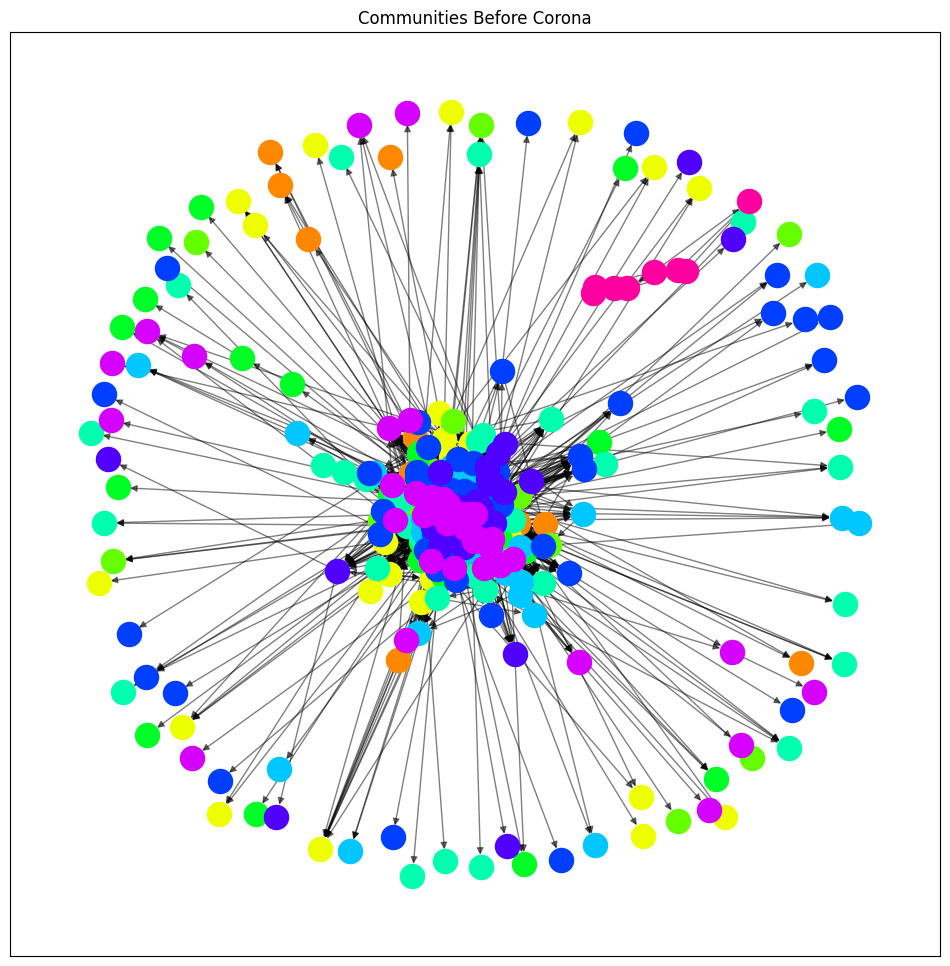

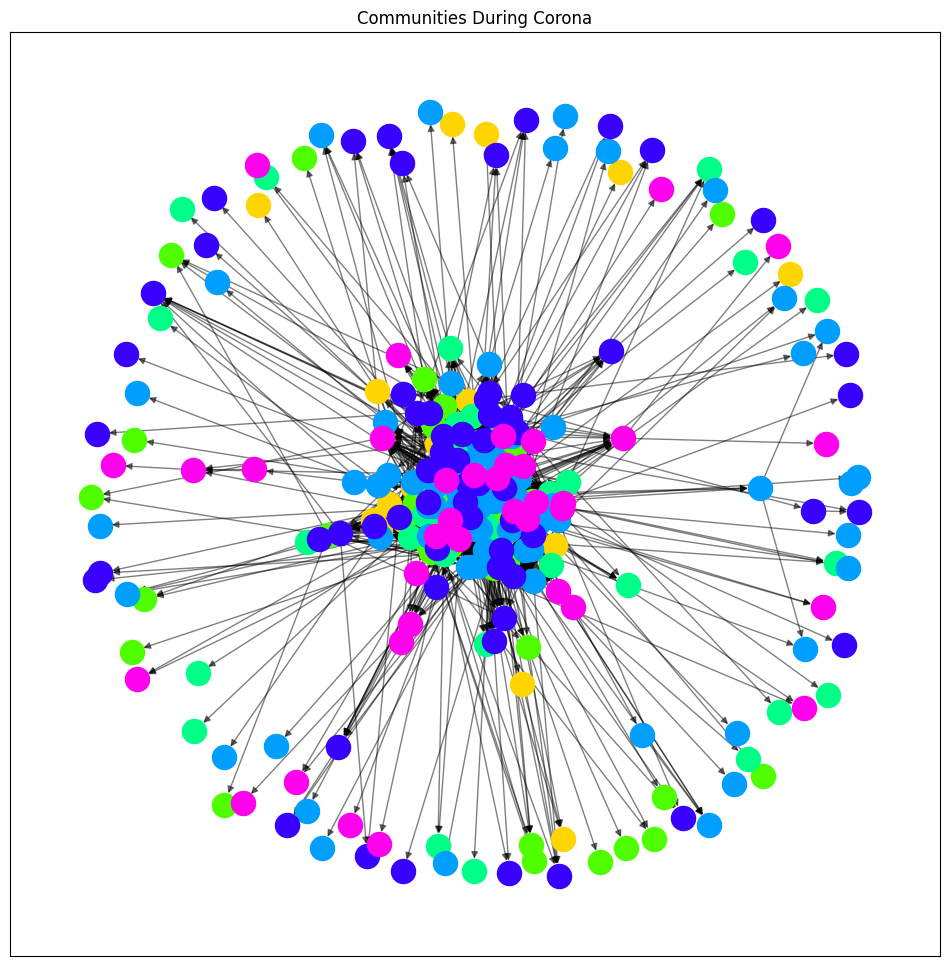

In [ ]:
def plot_communities(G, communities, title):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    colors = sns.color_palette("hsv", len(communities))
    for community, color in zip(communities, colors):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[color])
    plt.title(title)
    plt.show()

plot_communities(G_before_corona, communities_before_corona, 'Communities Before Corona')
plot_communities(G_corona, communities_corona, 'Communities During Corona')


Conclusions:
1. Girvan-Newman algorithm provided higher modularity scores before corona.
2. Louvain algorithm showed better performance during the corona period.
3. Central players changed between periods, indicating different strategies or impacts of the pandemic.

Research Question Answer:
The impact of the COVID-19 pandemic on tennis players' performances and results in ATP tournaments was significant.
There were shifts in central players, changes in community structures, and different strategies employed before and during the pandemic.